# **Useful links:**
- https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/dueling_ddqn_torch.py
- https://github.com/taldatech/pytorch-dqn-policy-gradient/blob/master/notebooks/Acrobot_Agent.ipynb

# **Installation**

In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

# **Imports**

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import os
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


# **Loading Enviroments**

In [3]:
def loading_env(enviroment):

    env = gym.make(enviroment)
    env.seed(0)

    state_shape = env.observation_space.shape[0]
    no_of_actions = env.action_space.n
    threshold_reward = env.spec.reward_threshold

    print("State Shape: ", state_shape)
    print("No of Actions: ",no_of_actions)
    print("Action Space Samples", env.action_space.sample())
    print("Threshold reward: ", threshold_reward)

    print("----")

    '''
    # Understanding State, Action, Reward Dynamics

    The agent decides an action to take depending on the state.

    The Environment keeps a variable specifically for the current state.
    - Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
    - It returns the new current state and reward for the agent to take the next action

    '''

    state = env.reset()
    ''' This returns the initial state (when environment is reset) '''

    print(state)
    print("----")

    action = env.action_space.sample()
    ''' We take a random action now '''

    print(action)
    print("----")

    next_state, reward, done, info = env.step(action)
    ''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

    print(next_state)
    print(reward)
    print(done)
    print(info)
    print("----")
    return env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Acrobot-v1 Enviroment**

In [4]:
acrobot_env = loading_env('Acrobot-v1')

State Shape:  6
No of Actions:  3
Action Space Samples 0
Threshold reward:  -100.0
----
[ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
0
----
[ 0.9998245   0.01873245  0.995746   -0.09214022  0.00529764 -0.3585254 ]
-1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


## **CartPole-v1 Enviroment**

In [5]:
cartpole_env = loading_env('CartPole-v1')

State Shape:  4
No of Actions:  2
Action Space Samples 0
Threshold reward:  475.0
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
1
----
[ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
1.0
False
{}
----


# **Replay Buffer**

In [6]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions, seed):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                    dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        self.seed = seed

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal


# **DuelingDQN**

In [7]:
class DuelingDQN(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(DuelingDQN, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        V = self.V(x)
        A = self.A(x)

        return V, A

# **DQN Agent**

In [8]:
class DQNAgent():
    def __init__(self, gamma, epsilon, lr, input_dims, n_actions,
                 mem_size, batch_size,update_type='Type-1', seed_value=0,
                 replace=100):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.replace_target_cnt = replace
        self.action_space = [i for i in range(self.n_actions)]
        self.learn_step_counter = 0
        self.update_type = update_type
        self.np_seed = np.random.seed(seed_value)
        self.torch_seed = torch.manual_seed(seed_value)


        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, seed_value)

        self.q_eval = DuelingDQN(self.lr, self.n_actions,
                                   input_dims=self.input_dims)


        self.q_next = DuelingDQN(self.lr, self.n_actions,
                                   input_dims=self.input_dims)

    def choose_action(self, observation):
        observations = np.array([observation])
        state = torch.tensor(observations).float().to(self.q_eval.device)
        if np.random.random() > self.epsilon:
            _, advantage = self.q_eval.forward(state)
            action = torch.argmax(advantage).item()
        else:
            action = np.random.choice(self.action_space)

        return action


    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
          self.q_next.load_state_dict(self.q_eval.state_dict())

    def reset(self, seed):
        self.learn_step_counter = 0
        self.epsilon = 1.0
        self.np_seed = np.random.seed(seed)
        self.torch_seed = torch.manual_seed(seed)
        self.memory = ReplayBuffer(self.mem_size, self.input_dims, self.n_actions, self.np_seed)

        self.q_eval = DuelingDQN(self.lr, self.n_actions,
                                   input_dims=self.input_dims)

        self.q_next = DuelingDQN(self.lr, self.n_actions,
                                   input_dims=self.input_dims)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = torch.tensor(state).to(self.q_eval.device)
        rewards = torch.tensor(reward).to(self.q_eval.device)
        dones = torch.tensor(done, dtype=torch.bool).to(self.q_eval.device)  # Convert to boolean dtype
        actions = torch.tensor(action).to(self.q_eval.device)
        states_ = torch.tensor(new_state).to(self.q_eval.device)

        indices = np.arange(self.batch_size)

        V_s, A_s = self.q_eval.forward(states)
        V_s_, A_s_ = self.q_next.forward(states_)

        V_s_eval, A_s_eval = self.q_eval.forward(states_)

        if self.update_type == 'Type-1':
          q_pred = torch.add(V_s, (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions]
          q_next = torch.add(V_s_, (A_s_ - A_s_.mean(dim=1, keepdim=True)))
          q_eval = torch.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1, keepdim=True)))
        elif self.update_type == 'Type-2':
          q_pred = torch.add(V_s, (A_s - torch.max(A_s, dim=1, keepdim=True)[0]))[indices, actions]
          q_next = torch.add(V_s_, (A_s_ - torch.max(A_s_, dim=1, keepdim=True)[0]))
          q_eval = torch.add(V_s_eval, (A_s_eval - torch.max(A_s_eval, dim=1, keepdim=True)[0]))


        max_actions = torch.argmax(q_eval, dim=1)
        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1


# **Training Dueling DQN**

In [9]:
def train_dueling_dqn(agent, env_name, episodes=1000, max_t=500, batch_size=64, gamma=0.99,
                      epsilon_decay=0.995, epsilon_min=0.01, target_update=10):
    env = gym.make(env_name)
    all_scores = []

    for seed in range(5):
        scores = []
        torch.manual_seed(seed)
        np.random.seed(seed)
        agent.reset(seed)
        print("\nSeed Number: {}".format(seed))
        for i_episode in range(episodes):
            state = env.reset()
            env.seed(seed)
            done = False
            score = 0

            scores_window = deque(maxlen=100)
            for t in range(max_t):
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                agent.store_transition(state, action, reward, next_state, done)
                agent.learn()
                state = next_state
                score += reward
                if done:
                    break

            scores.append(score)
            scores_window.append(score)

            agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        all_scores.append(scores)

    return all_scores

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_type1_and_type2(type1_score, type2_score, algo_name):

    # Calculate mean and standard deviation for Type-1 scores
    type1_mean = np.mean(type1_score, axis=0)
    type1_std = np.std(type1_score, axis=0)

    # Calculate mean and standard deviation for Type-2 scores
    type2_mean = np.mean(type2_score, axis=0)
    type2_std = np.std(type2_score, axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot Type-1 scores
    plt.plot(type1_mean, label=f'Type-1 {algo_name}', color='blue')
    plt.fill_between(range(len(type1_mean)),
                    type1_mean - type1_std,
                    type1_mean + type1_std,
                    alpha=0.3, color='blue')

    # Plot Type-2 scores
    plt.plot(type2_mean, label=f'Type-2 {algo_name}', color='red')
    plt.fill_between(range(len(type2_mean)),
                    type2_mean - type2_std,
                    type2_mean + type2_std,
                    alpha=0.3, color='red')

    # Plot labels and legend
    plt.title(f'Comparison of Type-1 and Type-2 {algo_name}')
    plt.xlabel('Episodes')
    plt.ylabel('Average Score')
    plt.legend()

    # Show plot
    plt.show()


In [16]:
acrobot_agent_type1 = DQNAgent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=(6,),
                         n_actions=3, seed_value=0, mem_size=10000, batch_size=64, update_type='Type-1')

In [ ]:
print("Training Acrobot enviroment for Type-1...")
acrobot_agent_type1_scores = train_dueling_dqn(acrobot_agent_type1, 'Acrobot-v1', episodes=1000)

In [10]:
acrobot_agent_type2 = DQNAgent(gamma=0.99, epsilon=1.0, lr=0.0005, input_dims=(6,),
                          n_actions=2, mem_size=10000, batch_size=64, update_type='Type-2', replace=20)

In [ ]:
print("Training Acrobot enviroment for Type-2...")
acrobot_agent_type2_scores = train_dueling_dqn(acrobot_agent_type2, 'Acrobot-v1', episodes=1000, max_t=500, epsilon_decay=0.995, epsilon_min=0.001,)

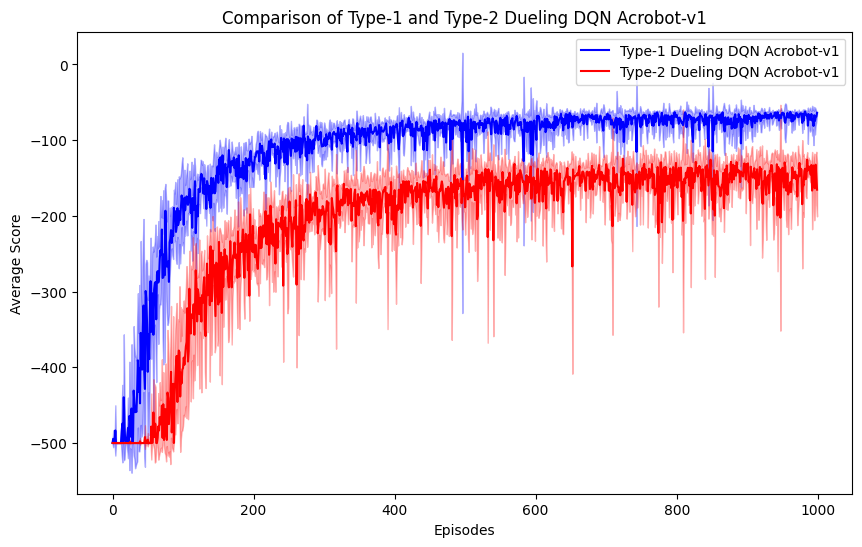

In [ ]:
plot_type1_and_type2(acrobot_agent_type1_scores, acrobot_agent_type2_scores, "Dueling DQN Acrobot-v1")

# **CartPole-v1 Environment**

In [ ]:
cartpole_agent_type1 = DQNAgent(gamma=0.99, epsilon=1.0, lr=0.001, input_dims=(4,),
                         n_actions=2, seed_value=0, mem_size=10000, batch_size=64, update_type='Type-1')
cartpole_agent_type2 = DQNAgent(gamma=0.99, epsilon=1.0, lr=0.0005, input_dims=(4,),
                          n_actions=2, mem_size=10000, batch_size=64, update_type='Type-2')

In [ ]:
# CartPole-v1
print("Training CartPole-v1 enviroment for Type-1...")
cartpole_agent_type1_scores = train_dueling_dqn(cartpole_agent_type1, 'CartPole-v1', episodes=1000)

In [ ]:
# CartPole-v1
print("Training CartPole-v1 enviroment for Type-2...")
cartpole_agent_type2_scores = train_dueling_dqn(cartpole_agent_type2, 'CartPole-v1', episodes=1000)

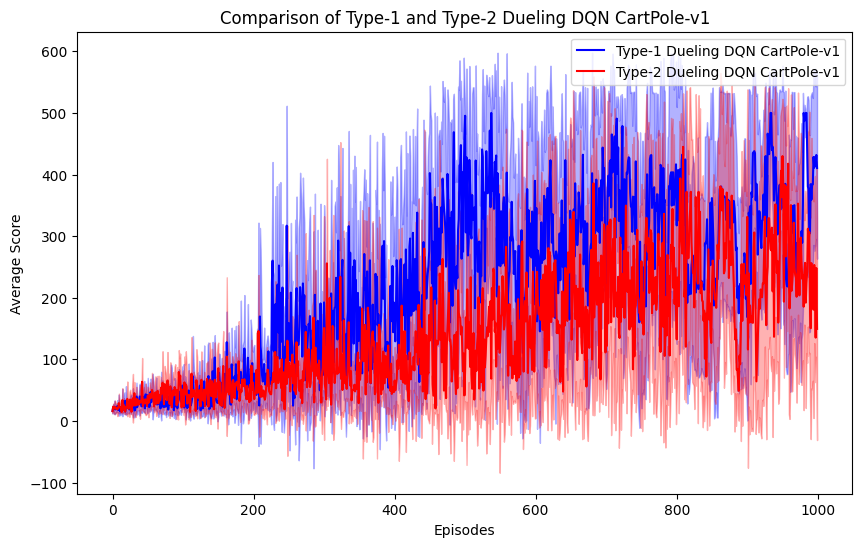

In [ ]:
plot_type1_and_type2(cartpole_agent_type1_scores, cartpole_agent_type2_scores, "Dueling DQN CartPole-v1")